In [3]:
import os
import torch
from brain_image_text.networks.VAEtrimodal import VAEtrimodal
from modalities.Modality import Modality
from brain_image_text.networks.MLP_Brain import EncoderBrain, DecoderBrain
from brain_image_text.networks.MLP_Image import EncoderImage, DecoderImage
from brain_image_text.networks.MLP_Text import EncoderText, DecoderText
from itertools import chain, combinations

import pickle as pkl

# load flags
with open("/home/hyojinju/emosync/model_reproduce/BraVL/BraVL_EEG/logs/Brain_Image_Text_2023_05_27/data.pkl", "br") as f:
    flags = pkl.load(f)

def set_modalities():
    mod1 = Modality('brain', EncoderBrain(flags), DecoderBrain(flags),
                flags.class_dim, flags.style_m1_dim, 'normal')
    mod2 = Modality('image', EncoderImage(flags), DecoderImage(flags),
                flags.class_dim, flags.style_m2_dim, 'normal')
    mod3 = Modality('text', EncoderText(flags), DecoderText(flags),
                flags.class_dim, flags.style_m3_dim, 'normal')
    mods = {mod1.name: mod1, mod2.name: mod2, mod3.name: mod3}
    return mods

def set_subsets():
    num_mods = len(list(modalities.keys()))

    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3)
    (1,2,3)
    """
    xs = list(modalities)
    # note we return an iterator rather than a list
    subsets_list = chain.from_iterable(combinations(xs, n) for n in
                                        range(len(xs)+1))
    subsets = dict()
    for k, mod_names in enumerate(subsets_list):
        mods = []
        for l, mod_name in enumerate(sorted(mod_names)):
            mods.append(modalities[mod_name])
        key = '_'.join(sorted(mod_names))
        subsets[key] = mods
    return subsets

modalities = set_modalities()
subsets = set_subsets()

load_path = '/home/hyojinju/emosync/model_reproduce/BraVL/BraVL_EEG/logs/Brain_Image_Text_2023_05_27/checkpoints/0499/mm_vae'
mm_vae = VAEtrimodal(flags, modalities, subsets)
mm_vae = mm_vae.to(flags.device)
mm_vae.load_state_dict(torch.load(load_path))
mm_vae.eval()

VAEtrimodal(
  (encoders): ModuleDict(
    (brain): EncoderBrain(
      (enc): Sequential(
        (0): Sequential(
          (0): Linear(in_features=561, out_features=256, bias=True)
          (1): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): ReLU(inplace=True)
        )
      )
      (relu): ReLU()
      (hidden_mu): Linear(in_features=256, out_features=32, bias=True)
      (hidden_logvar): Linear(in_features=256, out_features=32, bias=True)
    )
    (image): EncoderImage(
      (enc): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): ReLU(inplace=True)
        )
      )
      (relu): ReLU()
      (hidden_mu): Linear(in_features=256, out_features=32, bias=True)
      (hidden_logvar): Linea

In [4]:
# load dataset
import numpy as np 
import scipy.io as sio
from sklearn.model_selection import train_test_split

def set_dataset():
    # load data
    data_dir_root = flags.data_dir_root
    sbj = flags.sbj
    image_model = flags.image_model
    text_model = flags.text_model
    roi = flags.roi
    brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)
    image_dir_train = os.path.join(data_dir_root, 'visual_feature/ThingsTrain', image_model, sbj)
    image_dir_test = os.path.join(data_dir_root, 'visual_feature/ThingsTest', image_model, sbj)
    text_dir_train = os.path.join(data_dir_root, 'textual_feature/ThingsTrain/text', text_model, sbj)
    text_dir_test = os.path.join(data_dir_root, 'textual_feature/ThingsTest/text', text_model, sbj)

    train_brain = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['data'].astype('double') * 2.0
    # train_brain = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_between.mat'))['data'].astype('double')*2.0
    train_brain = train_brain[:,:,27:60] # 70ms-400ms
    train_brain = np.reshape(train_brain, (train_brain.shape[0], -1))
    train_image = sio.loadmat(os.path.join(image_dir_train, 'feat_pca_train.mat'))['data'].astype('double')*50.0
    train_text = sio.loadmat(os.path.join(text_dir_train, 'text_feat_train.mat'))['data'].astype('double')*2.0
    train_label = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')
    train_image = train_image[:,0:100]

    # test_brain = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data_unique.mat'))['data'].astype('double')*2.0
    # test_brain = test_brain[:, :, 27:60]
    # test_brain = np.reshape(test_brain, (test_brain.shape[0], -1))
    # test_image = sio.loadmat(os.path.join(image_dir_test, 'feat_pca_test_unique.mat'))['data'].astype('double')*50.0
    # test_text = sio.loadmat(os.path.join(text_dir_test, 'text_feat_test_unique.mat'))['data'].astype('double')*2.0
    # test_label = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data_unique.mat'))['class_idx'].T.astype('int')
    # train_image = train_image[:, 0:100]


    test_brain = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['data'].astype('double')*2.0
    test_brain = test_brain[:, :, 27:60]
    test_brain = np.reshape(test_brain, (test_brain.shape[0], -1))
    test_image = sio.loadmat(os.path.join(image_dir_test, 'feat_pca_test.mat'))['data'].astype('double')*50.0
    test_text = sio.loadmat(os.path.join(text_dir_test, 'text_feat_test.mat'))['data'].astype('double')*2.0
    test_label = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['class_idx'].T.astype('int')
    test_image = test_image[:, 0:100]

    if flags.aug_type == 'image_text_ilsvrc2012_val':
        image_dir_aug = os.path.join(data_dir_root, 'visual_feature/Aug_ILSVRC2012_val', image_model, sbj)
        text_dir_aug = os.path.join(data_dir_root, 'textual_feature/Aug_ILSVRC2012_val/text', text_model, sbj)
        aug_image = sio.loadmat(os.path.join(image_dir_aug, 'feat_pca_aug_ilsvrc2012_val.mat'))['data'].astype('double')
        aug_image = aug_image[:, 0:100]
        aug_text = sio.loadmat(os.path.join(text_dir_aug, 'text_feat_aug_ilsvrc2012_val.mat'))['data'].astype('double')
        aug_image = torch.from_numpy(aug_image)
        aug_text = torch.from_numpy(aug_text)
        print('aug_image=', aug_image.shape)
        print('aug_text=', aug_text.shape)
    elif flags.aug_type == 'no_aug':
        print('no augmentation')

    if flags.test_type=='normal':
        train_label_stratify = train_label
        train_brain, val_brain, train_label, val_label = train_test_split(train_brain, train_label_stratify, test_size=0.2, stratify=train_label_stratify)
        train_image, val_image, train_label, val_label = train_test_split(train_image, train_label_stratify, test_size=0.2, stratify=train_label_stratify)
        train_text, val_text, train_label, val_label = train_test_split(train_text, train_label_stratify, test_size=0.2, stratify=train_label_stratify)

        val_brain = torch.from_numpy(val_brain)
        val_image = torch.from_numpy(val_image)
        val_text = torch.from_numpy(val_text)
        val_label = torch.from_numpy(val_label)
        print('val_brain=', val_brain.shape)
        print('val_image=', val_image.shape)
        print('val_text=', val_text.shape)

    train_brain = torch.from_numpy(train_brain)
    test_brain = torch.from_numpy(test_brain)
    train_image = torch.from_numpy(train_image)
    test_image = torch.from_numpy(test_image)
    train_text = torch.from_numpy(train_text)
    test_text = torch.from_numpy(test_text)
    train_label = torch.from_numpy(train_label)
    test_label = torch.from_numpy(test_label)


    print('train_brain=', train_brain.shape)
    print('train_image=', train_image.shape)
    print('train_text=', train_text.shape)
    print('test_brain=', test_brain.shape)
    print('test_image=', test_image.shape)
    print('test_text=', test_text.shape)

    m1_dim = train_brain.shape[1]
    m2_dim = train_image.shape[1]
    m3_dim = train_text.shape[1]

    train_dataset = torch.utils.data.TensorDataset(train_brain, train_image, train_text, train_label)
    test_dataset = torch.utils.data.TensorDataset(test_brain, test_image, test_text,test_label)

    dataset_train = train_dataset
    dataset_test = test_dataset

    if flags.test_type == 'normal':
        val_dataset = torch.utils.data.TensorDataset(val_brain, val_image, val_text, val_label)
        dataset_val = val_dataset

    if 'image_text' in flags.aug_type:
        aug_dataset = torch.utils.data.TensorDataset(aug_image, aug_text)
        dataset_aug = aug_dataset
    elif flags.aug_type == 'no_aug':
        print('no augmentation')
    
    # set as Float
    # dataset_train = torch.tensor(dataset_train, dtype=torch.float32)
    # dataset_test = torch.tensor(dataset_test, dtype=torch.float32)
    # dataset_val = torch.tensor(dataset_val, dtype=torch.float32)

    return dataset_train, dataset_test

dataset_train, dataset_test = set_dataset()



no augmentation
train_brain= torch.Size([16540, 561])
train_image= torch.Size([16540, 100])
train_text= torch.Size([16540, 512])
test_brain= torch.Size([16000, 561])
test_image= torch.Size([16000, 100])
test_text= torch.Size([16000, 512])
no augmentation


In [5]:
# print(dataset_val.tensors)
def infer_image_text():
    with torch.no_grad():
        image_text_data = {'image': dataset_test.tensors[1].float().cuda(),'text': dataset_test.tensors[2].float().cuda()}
        label = dataset_test.tensors[3].float()
        brain = dataset_test.tensors[0].float()
        results = mm_vae(image_text_data)
        z = results['class_embeddings']
        brain_rec = mm_vae.lhoods['brain'](*mm_vae.decoders['brain'](None, z))

        return z.cpu().numpy(), label.cpu().numpy(), brain_rec.loc.cpu()
    
z, label, brain_rec = infer_image_text()


In [6]:
# data_dir_root = flags.data_dir_root
# sbj = flags.sbj
# image_model = flags.image_model
# text_model = flags.text_model
# roi = flags.roi
# brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)

# eeg_test = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))#['class_idx'].T.astype('int')
# # print(eeg_test)

# train_label = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')
# print(train_label[20])

train_label = dataset_train.tensors[3].float().cpu().numpy()
# val_label = dataset_val.tensors[3].float().cpu().numpy()
test_label = dataset_test.tensors[3].float().cpu().numpy()

print(train_label.shape)
# print(val_label.shape)
print(test_label)

# train_val = np.intersect1d(train_label, val_label)
# print(train_val.shape)
train_test = np.intersect1d(train_label, test_label)
print(train_test)
# val_test = np.intersect1d(val_label, test_label)
# print(val_test)

train_label_unique = np.unique(train_label)
print(train_label_unique.shape)
# val_label_unique = np.unique(val_label)
# print(val_label_unique.shape)
test_label_unique = np.unique(test_label)
print(test_label_unique.shape)

(16540, 1)
[[  1.]
 [  2.]
 [  3.]
 ...
 [198.]
 [199.]
 [200.]]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182.
 183. 184. 1

In [9]:
print(flags.aug_type)

no_aug


In [7]:
# data_dir_root = flags.data_dir_root
# sbj = flags.sbj
# image_model = flags.image_model
# text_model = flags.text_model
# roi = flags.roi
# brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)

# eeg_test = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))#['class_idx'].T.astype('int')
# # print(eeg_test)

# train_label = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')
# print(train_label[20])

train_text = dataset_train.tensors[2].float().cpu().numpy()
# val_label = dataset_val.tensors[3].float().cpu().numpy()
test_text = dataset_test.tensors[2].float().cpu().numpy()

print(train_text.shape)
# print(val_label.shape)
print(test_text.shape)

# train_val = np.intersect1d(train_label, val_label)
# print(train_val.shape)
train_test = np.intersect1d(train_text, test_text)
print(train_test.shape)
# val_test = np.intersect1d(val_label, test_label)
# print(val_test)

train_text_unique = np.unique(train_text)
print(train_text_unique.shape)
# val_label_unique = np.unique(val_label)
# print(val_label_unique.shape)
test_text_unique = np.unique(test_text)
print(test_text_unique.shape)

(16540, 512)
(16000, 512)
(15360,)
(7170467,)
(102334,)


In [8]:
import os

# Finding labels of z
novel_raw_dir = '/home/hyojinju/emosync/model_reproduce/BraVL/BraVL_EEG/data/ThingsEEG-Text/visual_feature/cornet_s/pretrained-True/layers-all/pca_feature_maps_test.npy'
novel_raw = np.load(novel_raw_dir, allow_pickle=True).flatten()[0]

print(novel_raw['all_layers'].shape)

labels_dict = {}
images_dir = '/home/hyojinju/emosync/model_reproduce/BraVL/BraVL_EEG/data/ThingsEEG-Text/visual_feature/test_images'
for d in sorted(os.listdir(images_dir)):
    sep_d = d.split("_", maxsplit=1)
    labels_dict[str(int(sep_d[0]))] = sep_d[1]
print(labels_dict)




(200, 3000)
{'1': 'aircraft_carrier', '2': 'antelope', '3': 'backscratcher', '4': 'balance_beam', '5': 'banana', '6': 'baseball_bat', '7': 'basil', '8': 'basketball', '9': 'bassoon', '10': 'baton4', '11': 'batter', '12': 'beaver', '13': 'bench', '14': 'bike', '15': 'birthday_cake', '16': 'blowtorch', '17': 'boat', '18': 'bok_choy', '19': 'bonnet', '20': 'bottle_opener', '21': 'brace', '22': 'bread', '23': 'breadbox', '24': 'bug', '25': 'buggy', '26': 'bullet', '27': 'bun', '28': 'bush', '29': 'calamari', '30': 'candlestick', '31': 'cart', '32': 'cashew', '33': 'cat', '34': 'caterpillar', '35': 'cd_player', '36': 'chain', '37': 'chaps', '38': 'cheese', '39': 'cheetah', '40': 'chest2', '41': 'chime', '42': 'chopsticks', '43': 'cleat', '44': 'cleaver', '45': 'coat', '46': 'cobra', '47': 'coconut', '48': 'coffee_bean', '49': 'coffeemaker', '50': 'cookie', '51': 'cordon_bleu', '52': 'coverall', '53': 'crab', '54': 'creme_brulee', '55': 'crepe', '56': 'crib', '57': 'croissant', '58': 'crow',

## Latent space 시각화

### tSNE

In [55]:
# Utils
def infer_brain():
    with torch.no_grad():
        data = {'brain': dataset_test.tensors[0].float().cuda()}
        label = dataset_test.tensors[3].float()
        results = mm_vae(data)
        z = results['class_embeddings']
        return z.cpu().numpy(), label.numpy()
    
def infer_image_text():
    with torch.no_grad():
        image_text_data = {'image': dataset_test.tensors[1].float().cuda(),'text': dataset_test.tensors[2].float().cuda()}
        label = dataset_test.tensors[3].float()
        brain = dataset_test.tensors[0].float()
        results = mm_vae(image_text_data)
        z = results['class_embeddings']
        brain_rec = mm_vae.lhoods['brain'](*mm_vae.decoders['brain'](None, z))

        return z.cpu().numpy(), label.cpu().numpy()
    
def infer_all():
    with torch.no_grad():
        data = {'brain': dataset_test.tensors[0].float().cuda(), 'image': dataset_test.tensors[1].float().cuda(),'text': dataset_test.tensors[2].float().cuda()}
        label = dataset_test.tensors[3].float()
        results = mm_vae(data)
        z = results['class_embeddings']
        return z.cpu().numpy(), label.numpy()

In [45]:
from sklearn.manifold import TSNE
import pandas as pd

latent_vectors, label = infer_image_text()
latent_vectors.shape

tsne_np = TSNE(n_components=2).fit_transform(latent_vectors)
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])
tsne_df['class'] = test_label

print(tsne_df)
print(latent_vectors.shape)
# Dataset image
# test_image = dataset_test.tensors[1].float().cpu().numpy()
# tsne_image = TSNE(n_components=2).fit_transform(test_image)
# tsne_image_df = pd.DataFrame(tsne_image, columns = ['component 0', 'component 1'])
# print(tsne_image_df)


       component 0  component 1  class
0        84.309875    35.293701    1.0
1        71.317490   -25.448750    2.0
2       -27.043232    22.902481    3.0
3       -57.375393   -32.457897    4.0
4       -24.303255   -27.571730    5.0
...            ...          ...    ...
15995     3.293990    31.444046  196.0
15996    22.128414    31.668587  197.0
15997   -11.338417    43.058048  198.0
15998    18.944304     4.377994  199.0
15999    -4.529148   -23.468941  200.0

[16000 rows x 3 columns]
(16000, 32)


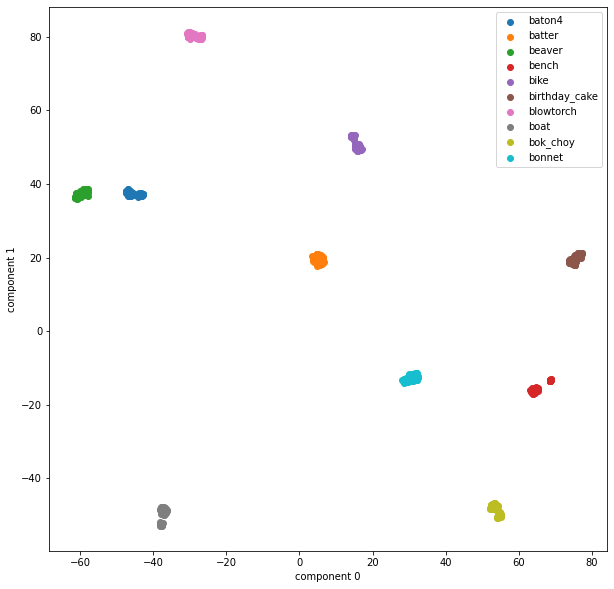

In [53]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_class_start = 10
num_class_end = 20

tsne_df_all = []
for i in range(1, num_class_end):
    tsne_df_all.append(tsne_df[tsne_df['class'] == i])

colorlist = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel('component 0')
plt.ylabel('component 1')
for i in range(num_class_start, num_class_end):
    x = tsne_df_all[i-1]['component 0']
    y = tsne_df_all[i-1]['component 1']
    ax.scatter(x, y, label=labels_dict[str(i)], alpha=1) # class별로 label 달아서 구분하기
# , c=colorlist[i%len(colorlist)]
plt.legend()
plt.show()


['aircraft_carrier', 'backscratcher', 'balance_beam', 'basil', 'baton4', 'boat', 'brace', 'bread', 'cd_player', 'chaps', 'coffee_bean', 'coffeemaker', 'coverall', 'creme_brulee', 'crepe', 'dragonfly', 'dreidel', 'duffel_bag', 'egg', 'espresso', 'folder', 'hoodie', 'jelly_bean', 'kettle', 'lampshade', 'lightning_bug', 'minivan', 'muff', 'mussel', 'okra', 'onion', 'panther', 'pie', 'pigeon', 'possum', 'pug', 'rhinoceros', 'rug', 'scooter', 'seagull', 'seed', 'sled', 'sleeping_bag', 'slide', 'spatula', 'stethoscope', 'treadmill', 'wallpaper', 'windshield', 'wok']
['banana', 'batter', 'bottle_opener', 'breadbox', 'bullet', 'cat', 'chain', 'chopsticks', 'cleat', 'cobra', 'cookie', 'croissant', 'crow', 'crumb', 'cupcake', 'drum', 'elephant', 'face_mask', 'ferry', 'glove', 'goose', 'grenade', 'hamburger', 'jukebox', 'lamb', 'laundry_basket', 'lettuce', 'manatee', 'music_box', 'orange', 'pear', 'pickax', 'pocket', 'pocketknife', 'popcorn', 'pretzel', 'purse', 'raspberry', 'recorder', 'rooster'

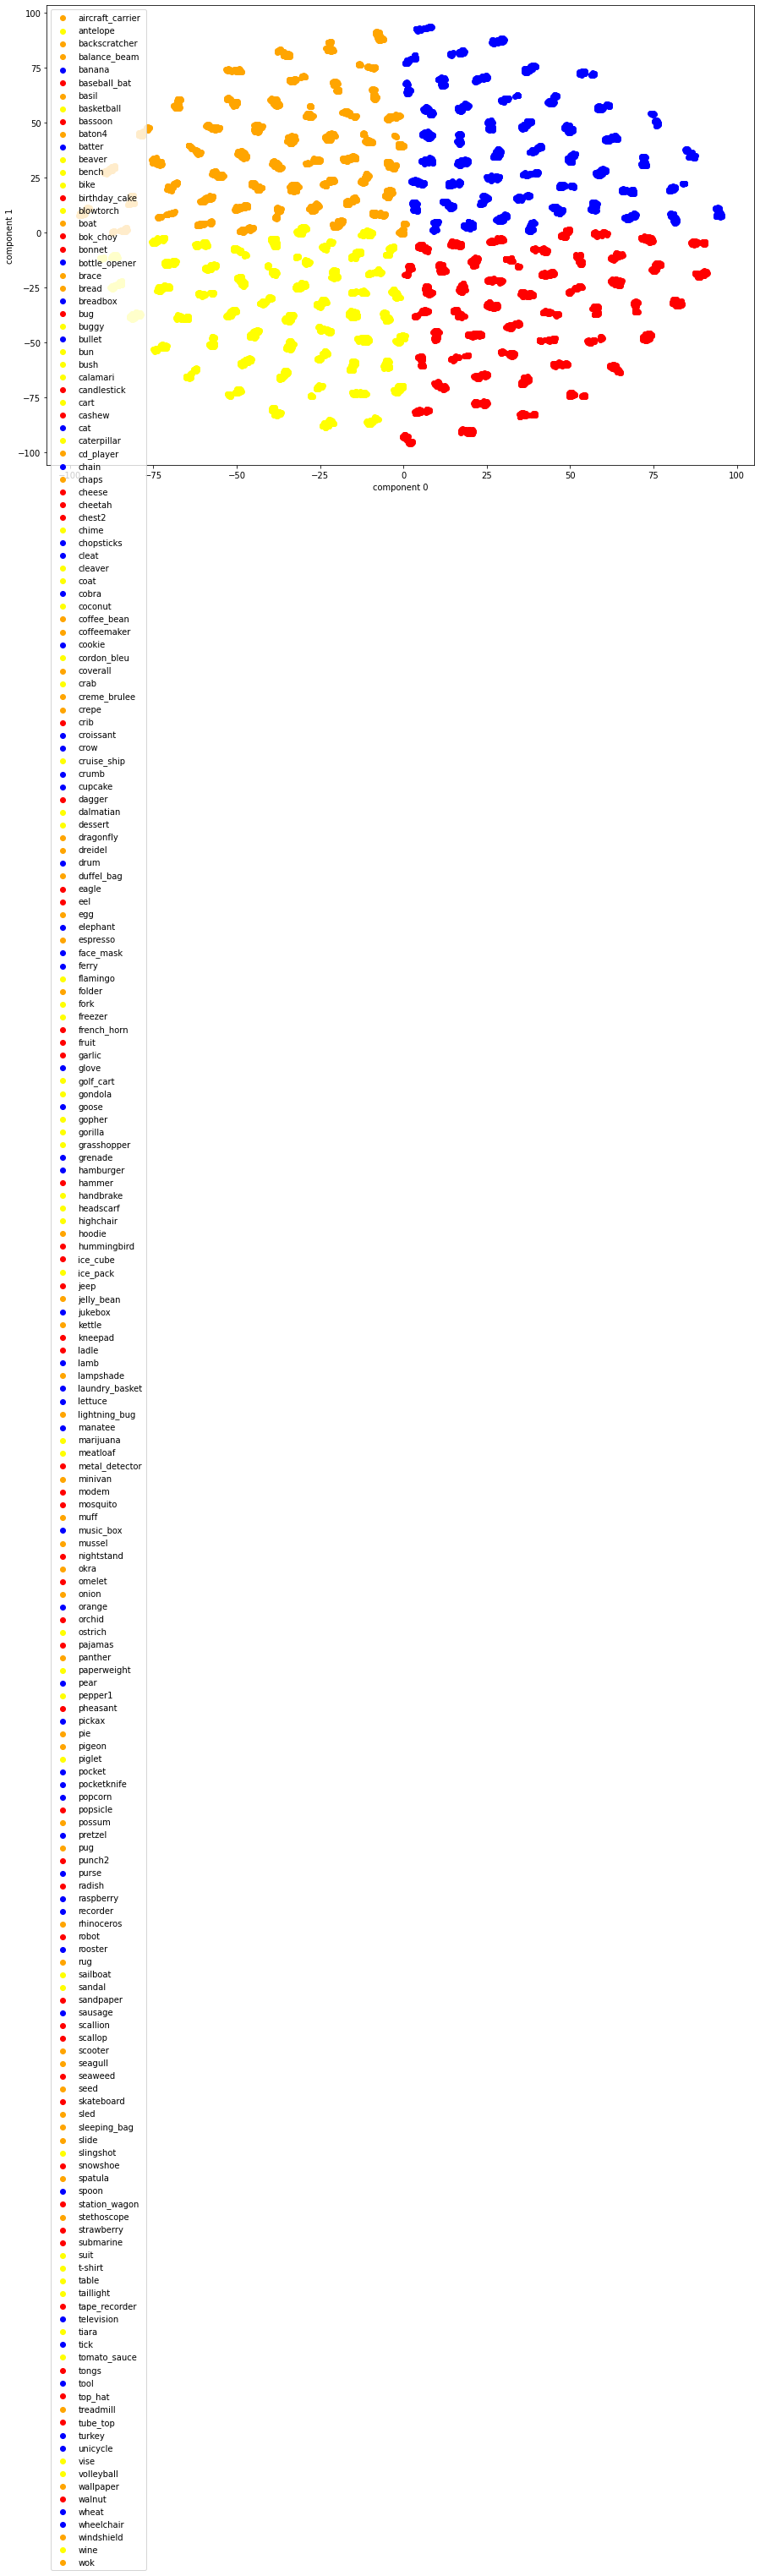

In [124]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
tsne_df_all = []
for i in range(1, 201):
    tsne_df_all.append(tsne_df[tsne_df['class'] == i])

colorlist = list(mcolors.CSS4_COLORS.keys())
ul = []
ur = []
bl = []
br = []

fig, ax = plt.subplots(figsize=(15,10))
plt.xlabel('component 0')
plt.ylabel('component 1')
near_x_zero = []
for i in range(1, 201):
    color = 'blue'
    x = tsne_df_all[i-1]['component 0']
    y = tsne_df_all[i-1]['component 1']

    if x.iloc[0] > 0 and y.iloc[0] > 0:
        color = 'blue'
        ur.append(labels_dict[str(i)])
    elif x.iloc[0] > 0 and y.iloc[0] <= 0:
        color = 'red'
        br.append(labels_dict[str(i)])
    elif x.iloc[0] <= 0 and y.iloc[0] > 0:
        color = 'orange'
        ul.append(labels_dict[str(i)])
    else:
        color = 'yellow'
        bl.append(labels_dict[str(i)])

    ax.scatter(x, y, c=color, label=labels_dict[str(i)]) # class별로 label 달아서 구분하기

print(ul)
print(ur)
print(bl)
print(br)
plt.legend()
plt.show()

{'aircraft_carrier': '1', 'antelope': '2', 'backscratcher': '3', 'balance_beam': '4', 'banana': '5', 'baseball_bat': '6', 'basil': '7', 'basketball': '8', 'bassoon': '9', 'baton4': '10', 'batter': '11', 'beaver': '12', 'bench': '13', 'bike': '14', 'birthday_cake': '15', 'blowtorch': '16', 'boat': '17', 'bok_choy': '18', 'bonnet': '19', 'bottle_opener': '20', 'brace': '21', 'bread': '22', 'breadbox': '23', 'bug': '24', 'buggy': '25', 'bullet': '26', 'bun': '27', 'bush': '28', 'calamari': '29', 'candlestick': '30', 'cart': '31', 'cashew': '32', 'cat': '33', 'caterpillar': '34', 'cd_player': '35', 'chain': '36', 'chaps': '37', 'cheese': '38', 'cheetah': '39', 'chest2': '40', 'chime': '41', 'chopsticks': '42', 'cleat': '43', 'cleaver': '44', 'coat': '45', 'cobra': '46', 'coconut': '47', 'coffee_bean': '48', 'coffeemaker': '49', 'cookie': '50', 'cordon_bleu': '51', 'coverall': '52', 'crab': '53', 'creme_brulee': '54', 'crepe': '55', 'crib': '56', 'croissant': '57', 'crow': '58', 'cruise_shi

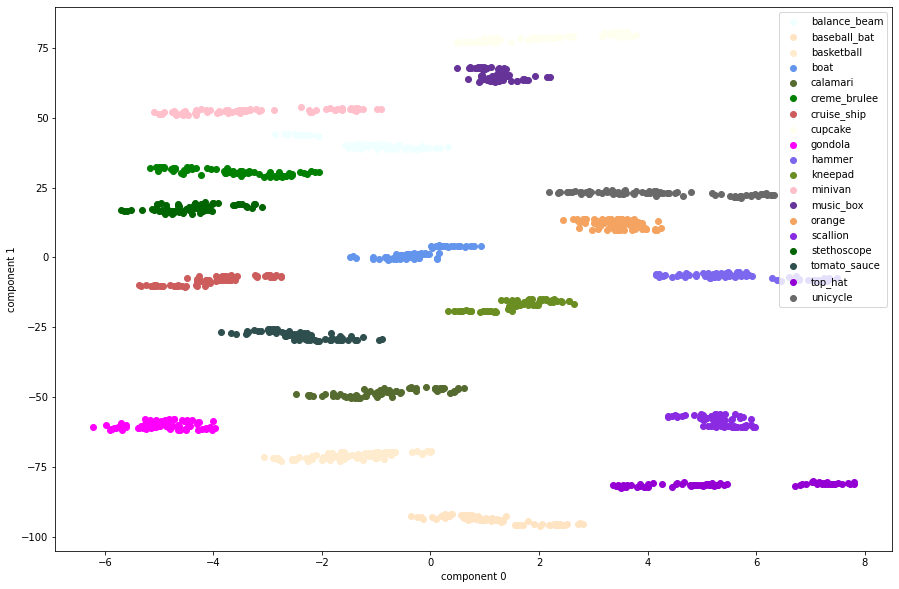

In [126]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# tsne_df_all = []
# for i in range(1, 201):
#     tsne_df_all.append(tsne_df[tsne_df['class'] == i])

colorlist = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(figsize=(15,10))
plt.xlabel('component 0')
plt.ylabel('component 1')
near_x_zero = []
c_to_i_dict = dict(zip(labels_dict.values(), labels_dict.keys()))
print(c_to_i_dict)
near_x_zero = []

for i in range(1, 201):
    x = tsne_df_all[i-1]['component 0']
    y = tsne_df_all[i-1]['component 1']

    if x.iloc[0] <= 5 and x.iloc[0] >= -5:
        near_x_zero.append(labels_dict[str(i)])

for c in near_x_zero:
    i = int(c_to_i_dict[c])
    # color = 'blue'
    x = tsne_df_all[i-1]['component 0']
    y = tsne_df_all[i-1]['component 1']

    ax.scatter(x, y, c=colorlist[i%len(colorlist)], label=c) # class별로 label 달아서 구분하기

print(near_x_zero)
plt.legend()
plt.show()

In [33]:
# z infered from EEG
def infer_brain():
    with torch.no_grad():
        data = {'brain': dataset_test.tensors[0].float().cuda()}
        label = dataset_test.tensors[3].float()
        results = mm_vae(data)
        z = results['class_embeddings']
        return z.cpu().numpy(), label.numpy()

z_eeg, label = infer_brain()

tsne_np_eeg = TSNE(n_components=2).fit_transform(z_eeg)
tsne_df_eeg = pd.DataFrame(tsne_np_eeg, columns = ['component 0', 'component 1'])
tsne_df_eeg['class'] = test_label

print(tsne_df_eeg)
print(z_eeg.shape)
        

NameError: name 'TSNE' is not defined

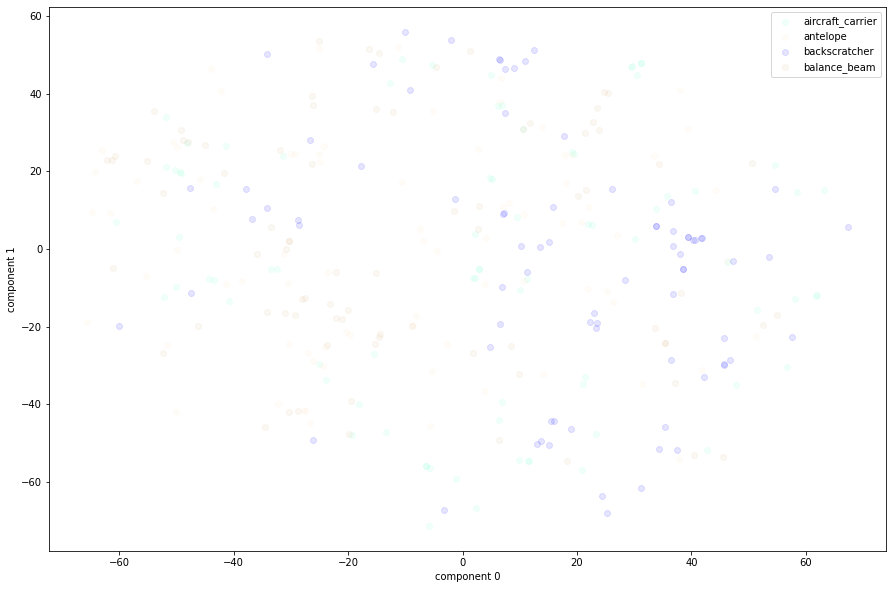

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
class_num = 5
tsne_df_eeg_all = []
for i in range(1, class_num):
    tsne_df_eeg_all.append(tsne_df_eeg[tsne_df_eeg['class'] == i])

colorlist = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(figsize=(15,10))
plt.xlabel('component 0')
plt.ylabel('component 1')
for i in range(1, class_num):
    x = tsne_df_eeg_all[i-1]['component 0']
    y = tsne_df_eeg_all[i-1]['component 1']
    ax.scatter(x, y, c=colorlist[(i*3)%len(colorlist)], label=labels_dict[str(i)], alpha=0.1) # class별로 label 달아서 구분하기

plt.legend()
plt.show()


In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
tsne_df_all = []
for i in range(1, 5):
    tsne_df_all.append(tsne_df[tsne_df['class'] == i])

colorlist = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(figsize=(15,10))
plt.xlabel('component 0')
plt.ylabel('component 1')
for i in range(1, 5):
    x = tsne_df_all[i-1]['component 0']
    y = tsne_df_all[i-1]['component 1']
    ax.scatter(x, y, c=colorlist[i%len(colorlist)], label=labels_dict[str(i)], alpha=0.5) # class별로 label 달아서 구분하기

plt.legend()
plt.show()

NameError: name 'tsne_df' is not defined

### UMAP 시각화

In [10]:
import umap

reducer = umap.UMAP()
z, label = infer_image_text()
umap_em = reducer.fit_transform(z)
print(umap_em.shape)

(16000, 2)


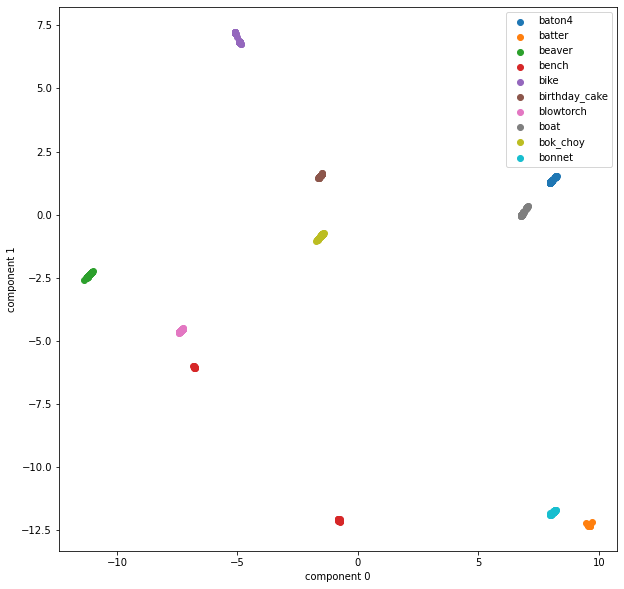

In [54]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

umap_df = pd.DataFrame(umap_em, columns = ['component 0', 'component 1'])
umap_df['class'] = test_label

num_class_start = 10
num_class_end = 20

umap_df_all = []
for i in range(1, num_class_end):
    umap_df_all.append(umap_df[umap_df['class'] == i])

colorlist = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel('component 0')
plt.ylabel('component 1')
for i in range(num_class_start, num_class_end):
    x = umap_df_all[i-1]['component 0']
    y = umap_df_all[i-1]['component 1']
    ax.scatter(x, y, label=labels_dict[str(i)], alpha=1) # class별로 label 달아서 구분하기
#, c=colorlist[(i+4)%len(colorlist)]
plt.legend()
plt.show()

In [39]:
import umap

reducer_eeg = umap.UMAP()
z_eeg, label = infer_brain()
umap_em_eeg = reducer_eeg.fit_transform(z_eeg)
print(umap_em_eeg.shape)

(16000, 2)


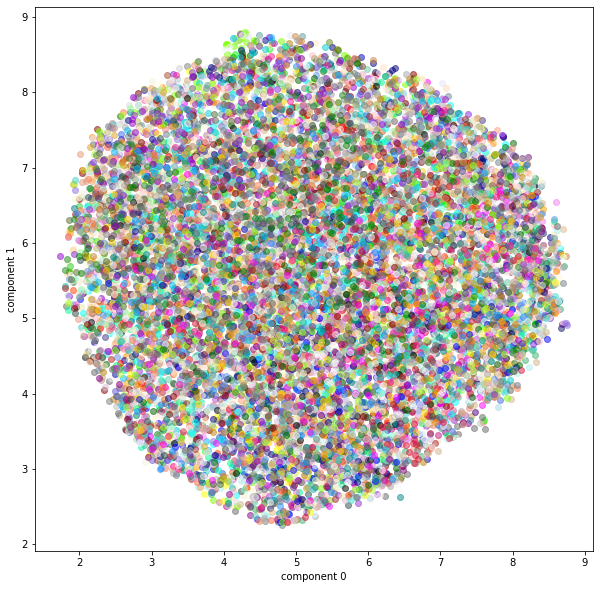

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

umap_df_eeg = pd.DataFrame(umap_em_eeg, columns = ['component 0', 'component 1'])
umap_df_eeg['class'] = test_label

num_class_start = 1
num_class_end = 201

umap_df_eeg_all = []
for i in range(1, num_class_end):
    umap_df_eeg_all.append(umap_df_eeg[umap_df_eeg['class'] == i])

colorlist = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel('component 0')
plt.ylabel('component 1')
for i in range(num_class_start, num_class_end):
    x = umap_df_eeg_all[i-1]['component 0']
    y = umap_df_eeg_all[i-1]['component 1']
    ax.scatter(x, y,c=colorlist[(i+4)%len(colorlist)], label=labels_dict[str(i)], alpha=0.5) # class별로 label 달아서 구분하기
#, c=colorlist[(i+4)%len(colorlist)]
# plt.legend()
plt.show()

In [57]:
# Umap infer all
import umap

reducer_all = umap.UMAP()
z_all, label = infer_all()
umap_em_all = reducer_all.fit_transform(z_all)



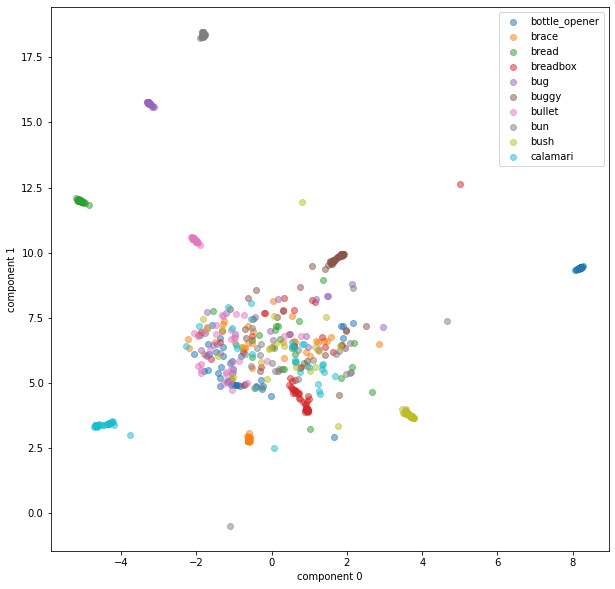

In [63]:
import pandas as pd

umap_df_all = pd.DataFrame(umap_em_all, columns=['component 0', 'component 1'])
umap_df_all['class'] = test_label

num_class_start = 20
num_class_end = 30

umap_df_all_all = []
for i in range(1, num_class_end):
    umap_df_all_all.append(umap_df_all[umap_df_all['class'] == i])

colorlist = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel('component 0')
plt.ylabel('component 1')
for i in range(num_class_start, num_class_end):
    x = umap_df_all_all[i-1]['component 0']
    y = umap_df_all_all[i-1]['component 1']
    ax.scatter(x, y, label=labels_dict[str(i)], alpha=0.5) # class별로 label 달아서 구분하기
#, c=colorlist[(i+4)%len(colorlist)]
plt.legend()
plt.show()